In [305]:
from collections import defaultdict
import pickle
import random
import re

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import little_mallet_wrapper as lmw

In [306]:
data_directory_path   = '/Volumes/Passport-1/data/birth-control'
output_directory_path = '/Volumes/Passport-1/output/birth-control'

In [307]:
dicts_to_plot = []

<br><br>

# REDDIT POSTS

In [308]:
data_path   = data_directory_path + '/final-data/reddit_posts.csv'
labels_path = data_directory_path + '/labeling/majority.reddit_posts.csv'

data_df   = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

len(data_df.index), len(labels_df.index)

(72731, 419)

In [309]:
labels_df['Label'].value_counts()

SEEKING INFORMATIONAL SUPPORT      200
SEEKING EXPERIENCES                111
SEEKING EMOTIONAL SUPPORT           71
PROVIDING EXPERIENCES               29
PROVIDING INFORMATIONAL SUPPORT      4
PROVIDING EMOTIONAL SUPPORT          2
DISCOURSE                            2
Name: Label, dtype: int64

In [310]:
for i, r in labels_df.iterrows():
    if r['ID'] == '66m3w9':
        print(r)

Unnamed: 0                                                  417
ID                                                       66m3w9
Label                                 SEEKING EMOTIONAL SUPPORT
Text          [TITLE: IUD falling out???] \n\nI got my parag...
Source                                             reddit-posts
Decision                                            two or more
Name: 417, dtype: object
Unnamed: 0                                                  418
ID                                                       66m3w9
Label                             SEEKING INFORMATIONAL SUPPORT
Text          [TITLE: IUD falling out???] \n\nI got my parag...
Source                                             reddit-posts
Decision                                            two or more
Name: 418, dtype: object


In [311]:
id_type_dict = pickle.load(open(data_directory_path + '/labeling/reddit.id_type_dict.pickle', 'rb'))
id_type_dict['ebmb78'] = 'pill'
# id_type_dict = {}
# for i, r in data_df.iterrows():
#     id_type_dict[r['id']] = r['text_type']

In [312]:
missing_list = []
for i, r in labels_df.iterrows():
    if r['ID'] not in id_type_dict:
        missing_list.append(r['ID'])
len(missing_list)

70

In [313]:
# for _id in missing_list:
#     print(_id)
#     for i, r in labels_df[labels_df['ID'] == _id].iterrows():
#         print(r['Text'])

In [314]:
def get_type_from_post(post_id):
    if post_id in id_type_dict:
        return id_type_dict[post_id]
    return 'Unknown'

print(len(list(labels_df['ID'].unique())))
labels_df['Type'] = labels_df['ID'].apply(get_type_from_post)
labels_df = labels_df[labels_df['Type'] != 'Unknown']
print(len(list(labels_df['ID'].unique())))

301
250


In [315]:
labels_df.sample(2)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type
90,90,jckupu,SEEKING INFORMATIONAL SUPPORT,[TITLE: bf came inside me and i forgot my pill...,reddit-posts,two or more,pill
323,323,14tpmo,SEEKING EXPERIENCES,[TITLE: my doctor has agreed to put in paragar...,reddit-posts,two or more,iud


In [316]:
label_type_count_dict = defaultdict(lambda: defaultdict(int))
for i, r in labels_df.iterrows():
    label_type_count_dict[r['Label']][r['Type']] += 1

for _label, _type_count_dict in label_type_count_dict.items():
    print(_label)
    for _type, _count in sorted(_type_count_dict.items(), key=lambda x: x[1], reverse=True):
        print(_count, '\t', _type)
    print()

SEEKING INFORMATIONAL SUPPORT
99 	 pill
45 	 iud
15 	 implant

SEEKING EXPERIENCES
45 	 iud
40 	 pill
9 	 implant

SEEKING EMOTIONAL SUPPORT
34 	 pill
21 	 iud
4 	 implant

PROVIDING EXPERIENCES
19 	 iud
7 	 pill
3 	 implant

PROVIDING EMOTIONAL SUPPORT
2 	 iud

PROVIDING INFORMATIONAL SUPPORT
2 	 iud
2 	 pill

DISCOURSE
1 	 pill
1 	 iud



In [317]:
for _label, _type_count_dict in label_type_count_dict.items():
    for _type, _count in _type_count_dict.items():
        dicts_to_plot.append({'Label': _label,
                              'Type': _type.lower(),
                              'Count': _count,
                              'Source': 'reddit-posts'})
len(dicts_to_plot)

17

In [318]:
reddit_posts_df = labels_df.copy()

In [319]:
def get_flair(post_id):
    if post_id in id_flair_dict:
        return id_flair_dict[post_id]
    return 'Unknown'
    
id_flair_dict = {}
for i, r in data_df.iterrows():
    id_flair_dict[r['id']] = r['link_flair_text']

labels_df['Flair'] = labels_df['ID'].apply(get_flair)
# labels_df = labels_df[labels_df['Flair'] != 'Unknown']
len(labels_df)

349

In [320]:
labels_df.sample(3)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type,Flair
162,162,d2qebo,SEEKING INFORMATIONAL SUPPORT,[TITLE: can i get a different iud?] \n\nI (23F...,reddit-posts,two or more,iud,Side effects!?
317,317,3ql32s,SEEKING INFORMATIONAL SUPPORT,[TITLE: nausea for 2 days after copper iud ins...,reddit-posts,two or more,iud,NaN
105,105,3y2boj,SEEKING INFORMATIONAL SUPPORT,"[TITLE: had an accident, need advice!] \n\nHi ...",reddit-posts,two or more,pill,NaN


In [321]:
len(labels_df['ID'].unique())

250

In [322]:
label_flair_count_dict = defaultdict(lambda: defaultdict(int))
for i, r in labels_df.iterrows():
    label_flair_count_dict[r['Label']][r['Flair']] += 1

flair_dicts = []
for _label, _flair_count_dict in label_flair_count_dict.items():
    for _flair, _count in _flair_count_dict.items():
        _flair = str(_flair).strip()
        if _flair == 'Side effects!?':
            _flair = 'Side Effects!?'
        if _flair == 'How to?':
            _flair = 'How to Use?'
        flair_dicts.append({'Label': _label,
                            'Flair': _flair,
                            'Count': _count,
                            'Source': 'reddit-posts'})

len(flair_dicts)

48

<br><br>

# REDDIT COMMENTS

In [323]:
data_path   = data_directory_path + '/final-data/reddit_comments.csv'
labels_path = data_directory_path + '/labeling/majority.reddit_comments.csv'

data_df   = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

len(data_df.index), len(labels_df.index)

(238568, 426)

In [324]:
id_type_dict = pickle.load(open(data_directory_path + '/labeling/reddit_comments.id_type_dict.pickle', 'rb'))
extra_id_type_dict = {'eohva35': 'pill',
                      'ff54ogg': 'iud',
                      'f2ujb26': 'pill',
                      'dzjo6xk': 'pill',
                      'dy0hxcy': 'iud',
                      'e70dmz8': 'iud',
                      'els1ptu': 'iud',
                      'esdcs80': 'pill',
                      'f3aynpg': 'pill',
                      'e9c8hdr': 'iud',
                      'f8ag2ct': 'pill',
                      'er9xnke': 'iud',
                      'evt051x': 'iud',
                      'dmiq49n': 'iud',
                      'dzucl4m': 'implant',
                      'esjk6gh': 'iud',
                      'ffbhk37': 'iud',
                      'e8byqhy': 'iud',
                      'f716aim': 'iud'}
for _id, _type in extra_id_type_dict.items():
    id_type_dict[_id] = _type
# id_type_dict = {}
# for i, r in data_df.iterrows():
#     id_type_dict[r['id']] = r['text_type']

In [325]:
missing_list = []
for i, r in labels_df.iterrows():
    if r['ID'] not in id_type_dict:
        missing_list.append(r['ID'])
len(missing_list)

79

In [326]:
# for _id in missing_list:
#     for i, r in labels_df[labels_df['ID'] == _id].iterrows():
#         print(_id)
#         print(r['Text'])
#         print('====================================================')

In [327]:
def get_type_from_post(post_id):
    if post_id in id_type_dict:
        return id_type_dict[post_id]
    return 'Unknown'

print(len(list(labels_df['ID'].unique())))
labels_df['Type'] = labels_df['ID'].apply(get_type_from_post)   # TODO: need to also get type from parent post
labels_df = labels_df[labels_df['Type'] != 'Unknown']
labels_df = labels_df[labels_df['Type'].isin(['pill', 'iud', 'implant'])]
print(len(list(labels_df['ID'].unique())))

342
252


In [328]:
target_ids = random.sample(list(labels_df['ID'].unique()), 250)
labels_df = labels_df[labels_df['ID'].isin(target_ids)]
len(labels_df.index)

313

In [329]:
labels_df.sample(2)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type
217,217,dmieka2,PROVIDING INFORMATIONAL SUPPORT,&gt; migraines with aura\n\nI concur. If your ...,reddit-comments,two or more,pill
385,385,fad8r9a,PROVIDING EMOTIONAL SUPPORT,I totally get where your girlfriend is coming ...,reddit-comments,two or more,iud


In [330]:
label_type_count_dict = defaultdict(lambda: defaultdict(int))
for i, r in labels_df.iterrows():
    label_type_count_dict[r['Label']][r['Type']] += 1

for _label, _type_count_dict in label_type_count_dict.items():
    print(_label)
    for _type, _count in sorted(_type_count_dict.items(), key=lambda x: x[1], reverse=True):
        print(_count, '\t', _type)
    print()

PROVIDING INFORMATIONAL SUPPORT
78 	 pill
33 	 iud
16 	 implant

PROVIDING EXPERIENCES
65 	 iud
44 	 pill
24 	 implant

PROVIDING EMOTIONAL SUPPORT
13 	 iud
13 	 pill
6 	 implant

DISCOURSE
4 	 iud
4 	 pill

SEEKING EXPERIENCES
2 	 iud
1 	 pill

SEEKING EMOTIONAL SUPPORT
2 	 iud
2 	 pill

SEEKING INFORMATIONAL SUPPORT
4 	 pill
2 	 iud



In [331]:
for _label, _type_count_dict in label_type_count_dict.items():
    for _type, _count in _type_count_dict.items():
        dicts_to_plot.append({'Label': _label,
                              'Type': _type.lower(),
                              'Count': _count,
                              'Source': 'reddit-comments'})
len(dicts_to_plot)

34

In [332]:
reddit_comments_df = labels_df.copy()

<br><br>

# TWITTER POSTS

In [333]:
category_keywords_dict_small = {'IUD': ['iud',
                                        'paragard',
                                        'paraguard',
                                        'kyleena'],
                                'Implant': ['nexplanon', 
                                            'implanon', 
                                            'bc implant',
                                            'birth control implant',
                                            'contraception implant',
                                            'contraceptive implant'],
                                'Pill': ['bc pill',
                                         'birth control pill',
                                         'contraceptive pill',
                                         'contraception pill',
                                         'oral contraceptive',
                                         'oral contraception',
                                         'oral birth control']}

In [334]:
data_path   = data_directory_path + '/final-data/twitter_posts.csv'
labels_path = data_directory_path + '/labeling/majority.twitter_posts.csv'

data_df   = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

len(data_df.index), len(labels_df.index)

(513108, 309)

In [335]:
labels_df['Tokens'] = labels_df['Text'].apply(lmw.process_string)

In [336]:
labels_df.sample(2)

,Unnamed: 0,ID,Label,Text,Source,Decision,Tokens
117,117,1242453401792909300,PROVIDING EXPERIENCES,Since I'm not on the birth control pill anymor...,twitter-posts,two or more,since birth control pill anymore period cramps...
60,60,1166077760932126700,DISCOURSE,Is that a fuckin IUD https://t.co/DZwtxJGq0z,twitter-posts,two or more,fuckin iud https //t co/dzwtxjgqNUMz


In [337]:
def get_type_from_twitter(tokens):
    for _category, _keywords in category_keywords_dict_small.items():
        for _keyword in _keywords:
            if _keyword in tokens.lower():
                return _category
    return 'Unknown'

print(len(list(labels_df['ID'].unique())))
labels_df['Type'] = labels_df['Text'].apply(get_type_from_twitter)
labels_df = labels_df[labels_df['Type'] != 'Unknown']
print(len(list(labels_df['ID'].unique())))

285
282


In [338]:
labels_df['Type'].value_counts()

IUD        146
Pill       118
Implant     41
Name: Type, dtype: int64

In [339]:
labels_df.sample(2)

,Unnamed: 0,ID,Label,Text,Source,Decision,Tokens,Type
65,65,1073094616059125800,PROVIDING EXPERIENCES,Ok so I’m having really bad cramps Rn and i JU...,twitter-posts,two or more,really bad cramps got period iud constant cram...,IUD
55,55,1248634691118399500,PROVIDING EXPERIENCES,The cramps I get due to having an IUD are wors...,twitter-posts,two or more,cramps get due iud worse cramps without iud,IUD


In [340]:
target_ids = random.sample(list(labels_df['ID'].unique()), 250)
labels_df = labels_df[labels_df['ID'].isin(target_ids)]
len(labels_df.index)

269

In [341]:
label_type_count_dict = defaultdict(lambda: defaultdict(int))
for i, r in labels_df.iterrows():
    label_type_count_dict[r['Label']][r['Type']] += 1

for _label, _type_count_dict in label_type_count_dict.items():
    print(_label)
    for _type, _count in sorted(_type_count_dict.items(), key=lambda x: x[1], reverse=True):
        print(_count, '\t', _type)
    print()

SEEKING EMOTIONAL SUPPORT
5 	 IUD
4 	 Implant

DISCOURSE
46 	 IUD
37 	 Pill
11 	 Implant

SEEKING EXPERIENCES
4 	 IUD
4 	 Implant
2 	 Pill

PROVIDING INFORMATIONAL SUPPORT
60 	 Pill
28 	 IUD
8 	 Implant

SEEKING INFORMATIONAL SUPPORT
5 	 IUD
3 	 Pill
2 	 Implant

PROVIDING EXPERIENCES
38 	 IUD
7 	 Implant
4 	 Pill

PROVIDING EMOTIONAL SUPPORT
1 	 IUD



In [342]:
for _label, _type_count_dict in label_type_count_dict.items():
    for _type, _count in _type_count_dict.items():
        dicts_to_plot.append({'Label': _label,
                              'Type': _type.lower(),
                              'Count': _count,
                              'Source': 'twitter-posts'})
len(dicts_to_plot)

52

In [343]:
twitter_posts_df = labels_df.copy()

<br><br>

# TWITTER REPLIES

In [344]:
data_path   = data_directory_path + '/final-data/twitter_replies.csv'
labels_path = data_directory_path + '/labeling/majority.twitter_replies.csv'

data_df   = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

len(data_df.index), len(labels_df.index)

(244240, 338)

In [345]:
id_type_dict = {}
for i, r in data_df.iterrows():
    id_type_dict[r['id']] = r['text_type']

In [346]:
missing_list = []
for i, r in labels_df.iterrows():
    if r['ID'] not in id_type_dict:
        missing_list.append(r['ID'])
len(missing_list)

325

In [347]:
def get_type_from_twitter(tokens):
    for _category, _keywords in category_keywords_dict_small.items():
        for _keyword in _keywords:
            if _keyword in tokens.lower():
                return _category
    return 'Unknown'

print(len(list(labels_df['ID'].unique())))
labels_df['Type'] = labels_df['Text'].apply(get_type_from_twitter)
labels_df = labels_df[labels_df['Type'] != 'Unknown']
print(len(list(labels_df['ID'].unique())))

283
282


In [348]:
labels_df.sample(2)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type
201,201,1261586581628031000,SEEKING INFORMATIONAL SUPPORT,"@LauraHolland The pill, as in the contraceptiv...",twitter-replies,two or more,Pill
26,26,1280887584269500400,SEEKING EMOTIONAL SUPPORT,@saadiegu it’s so annoying!!! my nexplanon is ...,twitter-replies,two or more,Implant


In [349]:
target_ids = random.sample(list(labels_df['ID'].unique()), 250)
labels_df = labels_df[labels_df['ID'].isin(target_ids)]
len(labels_df.index)

296

In [350]:
label_type_count_dict = defaultdict(lambda: defaultdict(int))
for i, r in labels_df.iterrows():
    label_type_count_dict[r['Label']][r['Type']] += 1

for _label, _type_count_dict in label_type_count_dict.items():
    print(_label)
    for _type, _count in sorted(_type_count_dict.items(), key=lambda x: x[1], reverse=True):
        print(_count, '\t', _type)
    print()

PROVIDING EXPERIENCES
113 	 IUD
15 	 Implant
6 	 Pill

PROVIDING INFORMATIONAL SUPPORT
37 	 IUD
15 	 Pill
6 	 Implant

DISCOURSE
58 	 IUD
17 	 Pill
4 	 Implant

SEEKING EXPERIENCES
1 	 IUD
1 	 Pill

SEEKING EMOTIONAL SUPPORT
6 	 IUD
2 	 Implant

SEEKING INFORMATIONAL SUPPORT
6 	 IUD
4 	 Pill

PROVIDING EMOTIONAL SUPPORT
5 	 IUD



In [351]:
for _label, _type_count_dict in label_type_count_dict.items():
    for _type, _count in _type_count_dict.items():
        dicts_to_plot.append({'Label': _label,
                              'Type': _type.lower(),
                              'Count': _count,
                              'Source': 'twitter-replies'})
len(dicts_to_plot)

68

In [352]:
twitter_replies_df = labels_df.copy()

<br><br>

# Combine into final dataframe and save

In [353]:
combined_final_df = pd.concat([reddit_posts_df, reddit_comments_df,twitter_posts_df, twitter_replies_df])
len(combined_final_df.index)

1227

In [354]:
for _dataset in combined_final_df['Source'].unique():
    print(_dataset)
    print(len(combined_final_df[combined_final_df['Source'] == _dataset]['ID'].unique()))

reddit-posts
250
reddit-comments
250
twitter-posts
250
twitter-replies
250


In [355]:
combined_final_df.to_csv(data_directory_path + '/labeling/final_labeled_df.csv')

In [356]:
combined_final_df.sample(3)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type,Tokens
380,380,dmvwrob,PROVIDING EXPERIENCES,I've had skyla since November of last year and...,reddit-comments,two or more,iud,NaN
50,50,f9hdgr5,PROVIDING EMOTIONAL SUPPORT,"Nah, you’re good. Promise. You’re not at any m...",reddit-comments,two or more,implant,NaN
80,80,762025831313072100,PROVIDING EMOTIONAL SUPPORT,@redheaded_wreck IUD is awful &amp; was so pai...,twitter-replies,two or more,IUD,NaN


<br><br>

# Plot label x type distributions

In [386]:
source_label_type_count_dict = defaultdict(int)
for i, r in combined_final_df.iterrows():
    source_label_type_count_dict[(r['Source'], r['Label'], r['Type'].lower())] += 1

for _source in combined_final_df['Source'].unique():
    for _label in combined_final_df['Label'].unique():
        for _type in combined_final_df['Type'].unique():
            if (_source, _label, _type.lower()) not in source_label_type_count_dict:
                source_label_type_count_dict[(_source, _label, _type.lower())] = 0

for (_source, _label, _type), _count in source_label_type_count_dict.items():
    print(_source, _label, _type, _count)

reddit-posts SEEKING INFORMATIONAL SUPPORT pill 99
reddit-posts SEEKING EXPERIENCES pill 40
reddit-posts SEEKING EMOTIONAL SUPPORT pill 34
reddit-posts PROVIDING EXPERIENCES iud 19
reddit-posts SEEKING EXPERIENCES iud 45
reddit-posts SEEKING INFORMATIONAL SUPPORT iud 45
reddit-posts SEEKING INFORMATIONAL SUPPORT implant 15
reddit-posts PROVIDING EXPERIENCES pill 7
reddit-posts SEEKING EMOTIONAL SUPPORT implant 4
reddit-posts PROVIDING EMOTIONAL SUPPORT iud 2
reddit-posts PROVIDING EXPERIENCES implant 3
reddit-posts SEEKING EMOTIONAL SUPPORT iud 21
reddit-posts PROVIDING INFORMATIONAL SUPPORT iud 2
reddit-posts SEEKING EXPERIENCES implant 9
reddit-posts PROVIDING INFORMATIONAL SUPPORT pill 2
reddit-posts DISCOURSE pill 1
reddit-posts DISCOURSE iud 1
reddit-comments PROVIDING INFORMATIONAL SUPPORT implant 16
reddit-comments PROVIDING EXPERIENCES implant 24
reddit-comments PROVIDING EMOTIONAL SUPPORT implant 6
reddit-comments PROVIDING EXPERIENCES iud 65
reddit-comments PROVIDING INFORMAT

In [387]:
dicts_to_plot = []
for (_source, _label, _type), _count in source_label_type_count_dict.items():
    dicts_to_plot.append({'Label': _label,
                          'Type': _type.lower(),
                          'Count': _count,
                          'Source': _source})
df_to_plot = pd.DataFrame(dicts_to_plot)
df_to_plot.sample(3)   

,Label,Type,Count,Source
71,DISCOURSE,implant,0,reddit-posts
53,PROVIDING INFORMATIONAL SUPPORT,pill,15,twitter-replies
50,SEEKING INFORMATIONAL SUPPORT,implant,2,twitter-posts


In [388]:
df_to_plot['Source'].value_counts()

twitter-posts      21
twitter-replies    21
reddit-comments    21
reddit-posts       21
Name: Source, dtype: int64

In [389]:
df_to_plot['Type'].value_counts()

implant    28
pill       28
iud        28
Name: Type, dtype: int64

In [390]:
for _type in ['iud', 'pill', 'implant']:
    _df = df_to_plot[df_to_plot['Type'] == _type]
    print(_type, '\t', _df['Count'].sum())

iud 	 609
pill 	 478
implant 	 140


In [391]:
for _source in df_to_plot['Source'].unique():
    _df = df_to_plot[df_to_plot['Source'] == _source]
    print(_source, '\t', _df['Count'].sum())

reddit-posts 	 349
reddit-comments 	 313
twitter-posts 	 269
twitter-replies 	 296


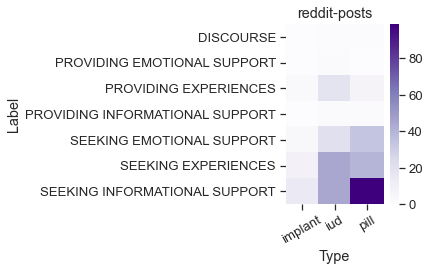

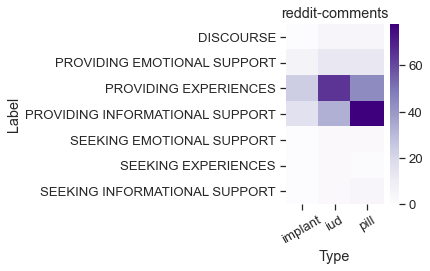

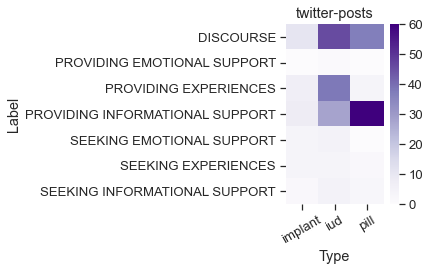

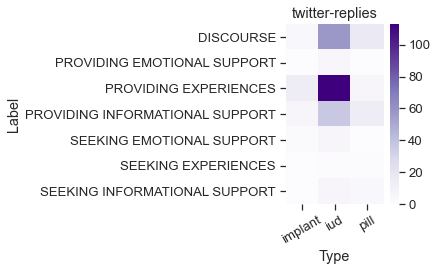

In [392]:
for _dataset in df_to_plot['Source'].unique():
    _target_df = df_to_plot[df_to_plot['Source'] == _dataset]
    _df_wide = _target_df.pivot_table(index='Label', 
                                      columns='Type', 
                                      values='Count')
    # _df_norm_col=(_df_wide-_df_wide.mean())/_df_wide.std()
        
    plt.figure(figsize=(6,4))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(_df_wide, cmap='Purples')    
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')
    # plt.xticks(rotation=30, ha='left')
    plt.xticks(rotation=30)
    plt.title(_dataset)
    plt.tight_layout()
    # plt.savefig(output_path)
    plt.show()

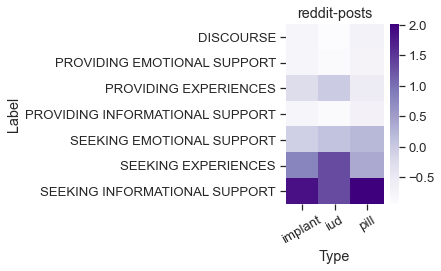

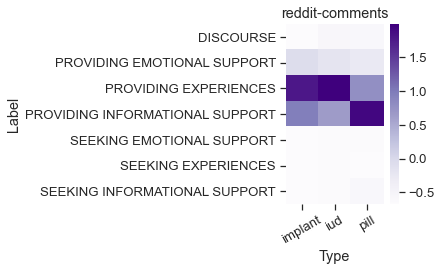

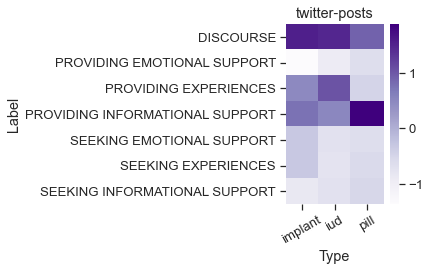

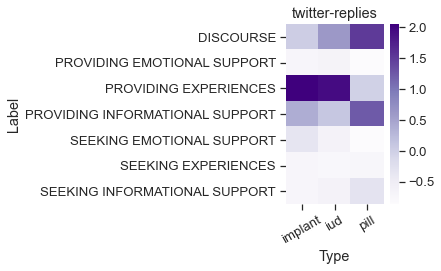

In [393]:
for _dataset in df_to_plot['Source'].unique():
    _target_df = df_to_plot[df_to_plot['Source'] == _dataset]
    _df_wide = _target_df.pivot_table(index='Label', 
                                      columns='Type', 
                                      values='Count')
    _df_norm_col=(_df_wide-_df_wide.mean())/_df_wide.std()
        
    plt.figure(figsize=(6,4))
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(_df_norm_col, cmap='Purples')    
    # ax.xaxis.tick_top()
    # ax.xaxis.set_label_position('top')
    # plt.xticks(rotation=30, ha='left')
    plt.xticks(rotation=30)
    plt.title(_dataset)
    plt.tight_layout()
    # plt.savefig(output_path)
    plt.show()

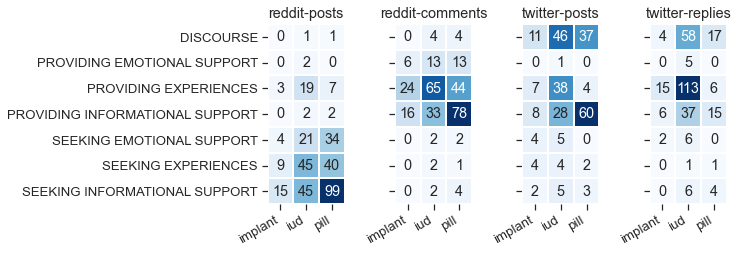

In [394]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d_norm_col =(d-d.mean())/d.std()
    sns.heatmap(d, **kwargs)
    plt.xticks(rotation=30, ha='right')
    plt.xlabel('')

fig = sns.FacetGrid(df_to_plot, col='Source', aspect=0.7, height=4)
fig.map_dataframe(draw_heatmap, 'Type', 'Label', 'Count', cmap='Blues', cbar=False, linewidths=1, annot=True, fmt='g', square=True)
for ax, title in zip(fig.axes.flat, ['reddit-posts', 'reddit-comments', 'twitter-posts', 'twitter-replies']):
    ax.set_title(title)
fig.set(xlabel=None, ylabel=None)
plt.savefig(output_directory_path + '/plots/labeling/facetgrid.heatmaps.type_x_label_x_source.pdf', bbox_inches='tight')

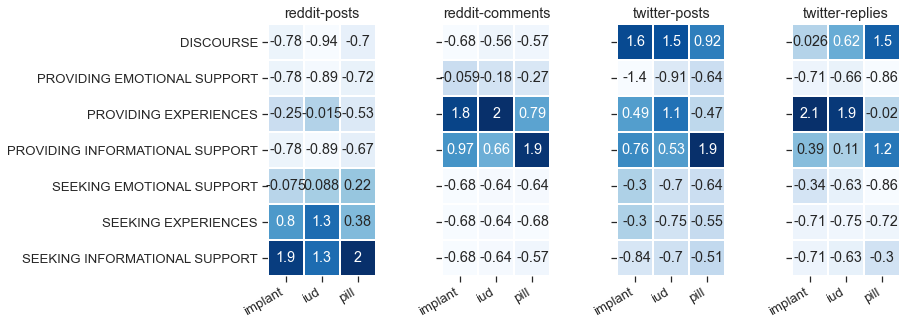

In [401]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d_norm_col =(d-d.mean())/d.std()
    sns.heatmap(d_norm_col, **kwargs)
    plt.xticks(rotation=30, ha='right')
    plt.xlabel('')

fig = sns.FacetGrid(df_to_plot, col='Source', aspect=0.7, height=5)
fig.map_dataframe(draw_heatmap, 'Type', 'Label', 'Count', cmap='Blues', cbar=False, linewidths=1, annot=True, square=True)
for ax, title in zip(fig.axes.flat, ['reddit-posts', 'reddit-comments', 'twitter-posts', 'twitter-replies']):
    ax.set_title(title)
fig.set(xlabel=None, ylabel=None)
plt.savefig(output_directory_path + '/plots/labeling/facetgrid.heatmaps.type_x_label_x_source.normalized.pdf', bbox_inches='tight')

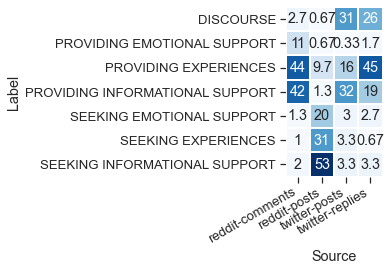

In [395]:
_df_wide = df_to_plot.pivot_table(index='Label', 
                                    columns='Source', 
                                    values='Count')
# _df_norm_col=(_df_wide-df_wide.mean())/_df_wide.std()
    
plt.figure(figsize=(6,4))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(_df_wide, cmap='Blues', cbar=False, linewidths=1, annot=True, square=True)  
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
# plt.savefig(output_path)
plt.show()

<br><br>

# Plot flair x labels

In [402]:
flair_df = pd.DataFrame(flair_dicts)
len(flair_df)

48

In [403]:
flair_df = flair_df[flair_df['Flair'] != 'nan']
len(flair_df)

44

In [404]:
flair_df['Flair'].value_counts()

Experience          11
Side Effects!?       9
Mistake or Risk?     6
Which Method?        5
Other                4
Rant!                3
How to Use?          3
Educational          2
Unknown              1
Name: Flair, dtype: int64

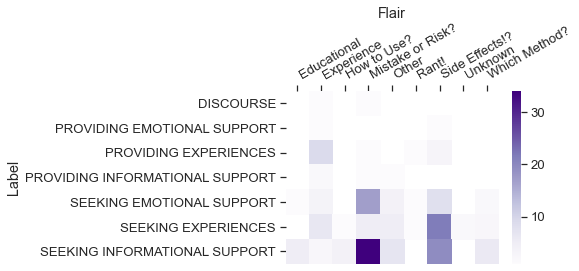

In [411]:
_df_wide = flair_df.pivot_table(index='Label', 
                                columns='Flair', 
                                values='Count')
# _df_norm_col=(_df_wide-_df_wide.mean())/_df_wide.std()
    
plt.figure(figsize=(8,4))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(_df_wide, cmap='Purples')    
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=30, ha='left')
# plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(output_directory_path + '/plots/labeling/facetgrid.heatmaps.type_x_flair_reddit.pdf', bbox_inches='tight')

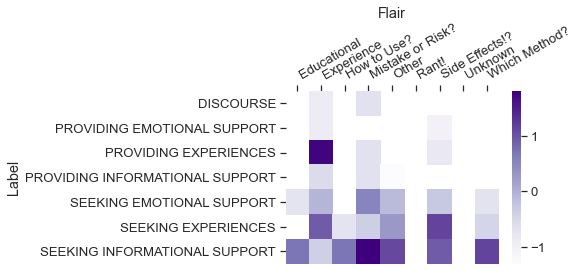

In [410]:
_df_wide = flair_df.pivot_table(index='Label', 
                                columns='Flair', 
                                values='Count')
_df_norm_col=(_df_wide-_df_wide.mean())/_df_wide.std()
    
plt.figure(figsize=(8,4))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(_df_norm_col, cmap='Purples')    
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=30, ha='left')
# plt.xticks(rotation=30, ha='right')
plt.tight_layout()
# plt.savefig(output_path)
plt.savefig(output_directory_path + '/plots/labeling/facetgrid.heatmaps.type_x_flair_reddit.normalized.pdf', bbox_inches='tight')

<br><br>

# Plot labels x datasets x TOPICS

In [412]:
import little_mallet_wrapper as lmw

In [416]:
combined_final_df['Tokens'] = combined_final_df['Text'].apply(lmw.process_string)

In [417]:
combined_final_df.sample(3)

,Unnamed: 0,ID,Label,Text,Source,Decision,Type,Tokens
338,338,aecr4e,SEEKING EMOTIONAL SUPPORT,[TITLE: pelvic pain after iud removal?] \n\nSo...,reddit-posts,two or more,iud,title pelvic pain iud removal long short story...
200,200,961048239897067500,DISCOURSE,GESTATED SUICIDE: two thoughts from my view; 1...,twitter-posts,two or more,Pill,gestated suicide two thoughts view NUM life ta...
184,184,1340124594787610600,PROVIDING INFORMATIONAL SUPPORT,"The pill, IUD and implant are all available in...",twitter-posts,two or more,IUD,pill iud implant available australia gps presc...


## REDDIT

In [524]:
num_topics = 35
path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'
topics_output_directory_path = output_directory_path + '/topics-by-leann/revision-final/reddit'

path_to_original_model                   = topics_output_directory_path + '/mallet.model.' + str(num_topics)
path_to_original_formatted_training_data = topics_output_directory_path + '/mallet.training'
path_to_new_formatted_training_data      = topics_output_directory_path + '/mallet.training.new'
path_to_new_training_data                = topics_output_directory_path + '/training.new.txt'
path_to_new_topic_distributions          = topics_output_directory_path + '/mallet.topic_distributions.' + str(num_topics) + '.new'

target_df = combined_final_df[combined_final_df['Source'].isin(['reddit-posts', 'reddit-comments'])]
training_data = combined_final_df['Tokens'].tolist()
training_ids = combined_final_df['ID'].tolist()

print('Importing data...')
lmw.import_data(path_to_mallet, 
                path_to_new_training_data, 
                path_to_new_formatted_training_data, 
                training_data, 
                training_ids=training_ids, 
                use_pipe_from=path_to_original_formatted_training_data)
print('Inferring topics...')
lmw.infer_topics(path_to_mallet, 
                 path_to_original_model, 
                 path_to_new_formatted_training_data, 
                 path_to_new_topic_distributions)
print('Load topic distributions...')
topic_distributions = lmw.load_topic_distributions(path_to_new_topic_distributions)
training_ids = lmw.load_training_ids(path_to_new_topic_distributions)

Importing data...
Importing data using pipe...
Complete
Inferring topics...
Inferring topics using pre-trained model...
Complete
Load topic distributions...


In [525]:
len(topic_distributions), len(training_ids)

(1227, 1227)

In [526]:
id_distribution_dict = {_id: _dist for _id, _dist in zip(training_ids, topic_distributions)}
len(id_distribution_dict)

1000

In [527]:
index_name_dict = {12: 'weight gain, losing weight',
                    16: 'general discussion of side effects',
                    26: 'iud insertion experience',
                    # 27: 'changing in periods, spotting',
                    34: 'heavy, light period, spotting',
                    28: 'implant experience'}

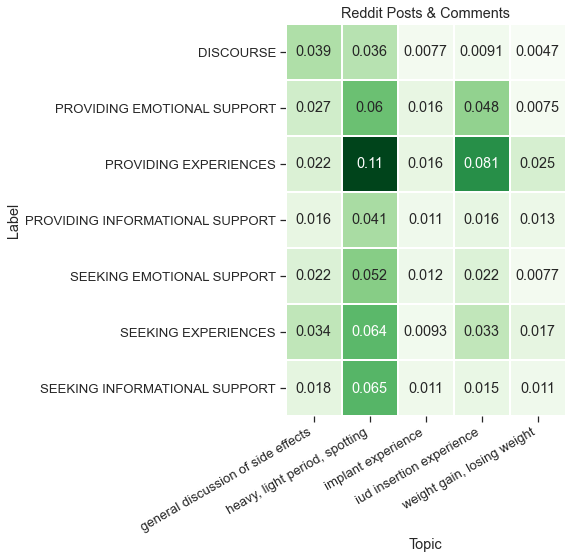

In [517]:
dicts_to_plot = []
for i, r in target_df.iterrows():
    for _topic_index in index_name_dict:
        dicts_to_plot.append({'Topic': index_name_dict[_topic_index],
                              'Probability': id_distribution_dict[r['ID']][_topic_index],
                              'Label': r['Label']})
df_to_plot = pd.DataFrame(dicts_to_plot)

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='Label', 
                                 columns='Topic', 
                                 values='Probability')
df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
    
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(df_wide, cmap='Greens', cbar=False, linewidths=1, annot=True, square=True)    
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
plt.xticks(rotation=30, ha='right')
plt.title('Reddit Posts & Comments')
plt.tight_layout()
plt.savefig(output_directory_path + '/plots/labeling/heatmap.label_x_topics.reddit.pdf', bbox_inches='tight')

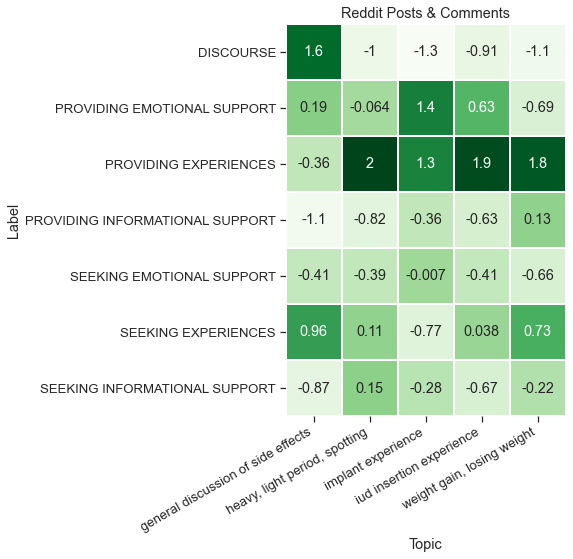

In [518]:
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(df_norm_col, cmap='Greens', cbar=False, linewidths=1, annot=True, square=True)    
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
plt.xticks(rotation=30, ha='right')
plt.title('Reddit Posts & Comments')
plt.tight_layout()
plt.savefig(output_directory_path + '/plots/labeling/heatmap.label_x_topics.reddit.normalized.pdf', bbox_inches='tight')

## TWITTER

In [519]:
num_topics = 35
path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'
topics_output_directory_path = output_directory_path + '/topics-by-leann/revision-final/twitter'

path_to_original_model                   = topics_output_directory_path + '/mallet.model.' + str(num_topics)
path_to_original_formatted_training_data = topics_output_directory_path + '/mallet.training'
path_to_new_formatted_training_data      = topics_output_directory_path + '/mallet.training.new'
path_to_new_training_data                = topics_output_directory_path + '/training.new.txt'
path_to_new_topic_distributions          = topics_output_directory_path + '/mallet.topic_distributions.' + str(num_topics) + '.new'

target_df = combined_final_df[combined_final_df['Source'].isin(['twitter-posts', 'twitter-replies'])]
training_data = combined_final_df['Tokens'].tolist()
training_ids = combined_final_df['ID'].tolist()

print(len(training_data), len(list(set(training_ids))))

print('Importing data...')
lmw.import_data(path_to_mallet, 
                path_to_new_training_data, 
                path_to_new_formatted_training_data, 
                training_data, 
                training_ids=training_ids, 
                use_pipe_from=path_to_original_formatted_training_data)
print('Inferring topics...')
lmw.infer_topics(path_to_mallet, 
                 path_to_original_model, 
                 path_to_new_formatted_training_data, 
                 path_to_new_topic_distributions)
print('Load topic distributions...')
topic_distributions = lmw.load_topic_distributions(path_to_new_topic_distributions)
training_ids = lmw.load_training_ids(path_to_new_topic_distributions)

1227 1000
Importing data...
Importing data using pipe...
Complete
Inferring topics...
Inferring topics using pre-trained model...
Complete
Load topic distributions...


In [520]:
id_distribution_dict = {_id: _dist for _id, _dist in zip(training_ids, topic_distributions)}
len(id_distribution_dict)

1000

In [521]:
index_name_dict = {14: 'weight gain, losing weight',
                    25: 'general discussion of side effects',
                    1: 'iud insertion experience',
                    32: 'heavy, light period, spotting',
                    0: 'implant experience'}

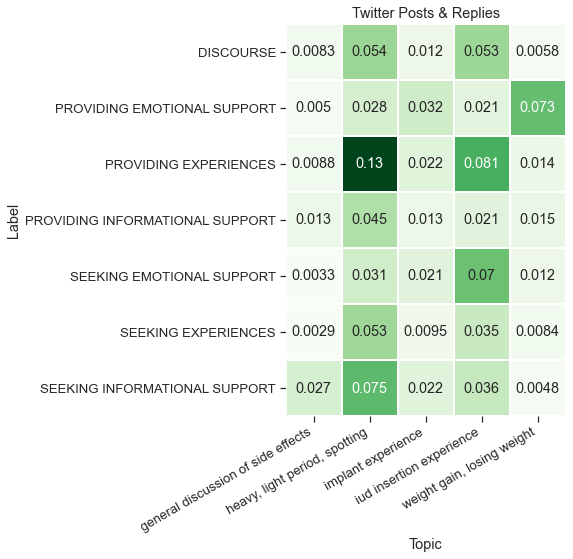

In [522]:
dicts_to_plot = []
for i, r in target_df.iterrows():
    for _topic_index in index_name_dict:
        dicts_to_plot.append({'Topic': index_name_dict[_topic_index],
                              'Probability': id_distribution_dict[str(r['ID'])][_topic_index],
                              'Label': r['Label']})
df_to_plot = pd.DataFrame(dicts_to_plot)

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='Label', 
                                 columns='Topic', 
                                 values='Probability')
df_norm_col = (df_wide-df_wide.mean())/df_wide.std()
    
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(df_wide, cmap='Greens', cbar=False, linewidths=1, annot=True, square=True)    
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
plt.xticks(rotation=30, ha='right')
plt.title('Twitter Posts & Replies')
plt.tight_layout()
plt.savefig(output_directory_path + '/plots/labeling/heatmap.label_x_topics.twitter.pdf', bbox_inches='tight')

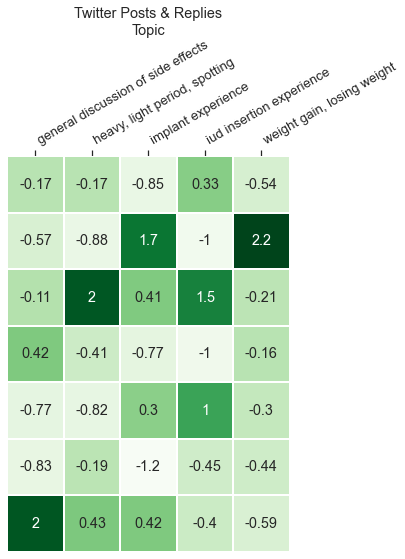

In [512]:
plt.figure(figsize=(8,8))
sns.set(style='ticks', font_scale=1.2)
ax = sns.heatmap(df_norm_col, cmap='Greens', cbar=False, linewidths=1, annot=True, square=True)    
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
# plt.xticks(rotation=30, ha='left')
plt.xticks(rotation=30, ha='right')
plt.title('Twitter Posts & Replies')
plt.yticks([])
plt.ylabel('')
plt.tight_layout()
plt.savefig(output_directory_path + '/plots/labeling/heatmap.label_x_topics.twitter.normalized.pdf', bbox_inches='tight')